In [1]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
import itertools
import pickle

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from picking.p_picking import p_picking_all, p_picking_each, p_picking_val
from picking.utils import optimize_parameters, load_best_params
from picking.plot import *


/home/lptv/anaconda3/envs/trigger_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_files(path, extensions):
    '''
    Entrega de vuelta un diccionario con la extensión del archivo como llave, y el path a cada archivo como valor

    '''
    file_list = {ext: [] for ext in list(extensions)}
    for root, dirs, files in os.walk(path):
        for file in files:
            for ext in extensions:
                if file.endswith(ext):
                    file_list[ext].append(os.path.join(root, file))

    return file_list


def sort_files(file_dic, extension):
    '''
    Junta los archivos por carpeta y canal. Queda un diccionario que tiene como llave la carpeta y el canal, 
    y como valor una lista con los paths a los archivos de esa carpeta y canal.   
    '''
    # Diccionario para almacenar los archivos por carpeta y canal
    grouped_files = defaultdict(list)
    key_names = []
    
    # Ordenar los archivos alfabéticamente antes de procesarlos
    sorted_files = sorted(file_dic[extension])
    
    for file in sorted_files:
        # Extraer la carpeta y el canal del path del archivo
        parts = os.path.split(file)
        folder = parts[0]  # La carpeta es el primer elemento en el path
        channel = parts[1].split('_')[0]  # El canal es el primer elemento en el nombre del archivo
        key = os.path.join(folder, channel)
        if [key] not in key_names:
            key_names.append([key])
        # Agrupar los archivos
        grouped_files[key].append(file)

    key_names = list(itertools.chain(*key_names))
    return grouped_files, key_names




In [3]:
files_bhz = find_files("señales_sismos/BHZ", ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

<img src="diagrama.png">

# 1. Preprocesamiento de las trazas

## 1.1. Lectura de las trazas sísmicas

***Ojo que la forma en que se ordenan las cosas es diferente en windows y linux, no se por què, ver esto***
- En la diferencia entre los archivos sta-lta.ipynb y energy.ipynb se van a evidencia las diferencias.
- Una es en la // de las funciones find_files y sort_files
- La otra es en aca abajo en como quedan ordenadas las trazas. AC04 quedan en 2 y CO05 queda en 0.

In [4]:
#estación AC04
AC04_st = files_bhz_ch[key_names_bhz[0]]
st_AC04_raw = read(AC04_st[0])
st_AC04_raw += read(AC04_st[1])
st_AC04_raw += read(AC04_st[2])


#estación adyacente 1: AC05
AC05_st = files_bhz_ch[key_names_bhz[1]]
st_AC05_raw = read(AC05_st[0])
st_AC05_raw += read(AC05_st[1])
st_AC05_raw += read(AC05_st[2])


#estación adyacente 2: CO05
CO05_st = files_bhz_ch[key_names_bhz[2]]
st_CO05_raw = read(CO05_st[0])
st_CO05_raw += read(CO05_st[1])
st_CO05_raw += read(CO05_st[2])

#estación adyacente 3: CO10
CO10_st = files_bhz_ch[key_names_bhz[3]]
st_CO10_raw = read(CO10_st[0])
st_CO10_raw += read(CO10_st[1])
st_CO10_raw += read(CO10_st[2])

### 1.1.1. Visualización de la señal AC04

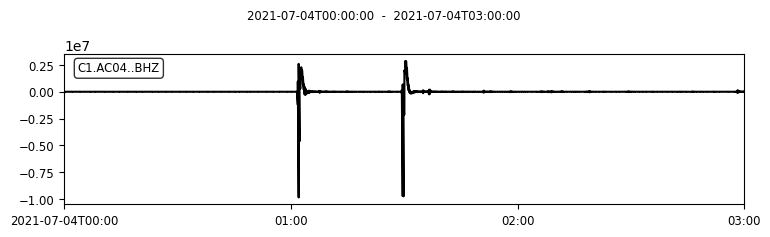

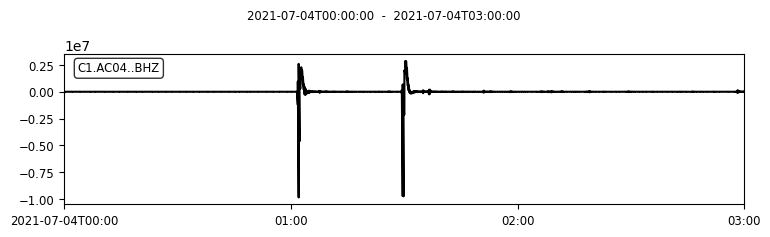

In [5]:
st_AC04_raw[2].plot(startime = st_AC04_raw[2].stats.starttime + 60*60 , endtime = st_AC04_raw[2].stats.starttime + 60*60*3)

## 1.2. Eliminación de respuesta de instrumentos

In [6]:
def remove_response(trace: Trace, inventory_filepath: str, remove_type: str = "obspy"):
    """
    Remove instrument response

    Args:
        trace (Trace): Trace object from obspy
        inventory_folder (str): Path to inventory folder
    """
    from obspy import read_inventory

    assert isinstance(trace, Trace), "trace must be a Trace object from obspy"

    trace_removed = trace.copy()

    inv = read_inventory(inventory_filepath)
        # Remove instrument response
    if remove_type == "obspy":
        trace_removed.remove_response(
            inventory=inv,
            output="VEL",
            zero_mean=False,
        )
    elif remove_type == "scalar":
        resp = inv.get_response(seed_id=trace_removed.get_id(), datetime=trace_removed.stats.starttime)
        #trace_removed.data *= 1/inv[0][0].response.instrument_sensitivity.value
        trace_removed.data *= 1/resp.instrument_sensitivity.value
        
    """inv = read_inventory(inventory_filepath)
        resp = inv.get_response(
            seed_id=trace_removed.get_id(), 
            datetime=trace_removed.stats.starttime)
        poles = resp.get_paz().poles
        zeros = resp.get_paz().zeros
        #gain = np.prod(list(map(lambda stage: stage.stage_gain, resp.response_stages)))
        sensitivity = resp.instrument_sensitivity.value
        for stage in resp.response_stages[::-1]:
            gain = stage.stage_gain
            paz_sts2 = {'poles': poles,
                'zeros': zeros,
                'gain': 1/gain,
                'sensitivity': sensitivity}
            trace_removed.simulate(paz_remove=paz_sts2)"""

    return trace_removed

In [7]:
remove_AC04 = os.path.join("inventory", "C1_AC04.xml")
remove_AC05 = os.path.join("inventory", "C1_AC05.xml")
remove_CO05 = os.path.join("inventory", "C1_CO05.xml")
remove_CO10 = os.path.join("inventory", "C1_CO10.xml")

In [8]:
st_AC04_resp = st_AC04_raw.copy()
st_AC05_resp = st_AC05_raw.copy()
st_CO05_resp = st_CO05_raw.copy()
st_CO10_resp = st_CO10_raw.copy()

In [9]:
st_AC04_removed = remove_response(st_AC04_resp.select(channel='BHZ')[0], remove_AC04 , 'obspy')
st_AC05_removed = remove_response(st_AC05_resp.select(channel='BHZ')[0], remove_AC05 , 'obspy')
st_CO05_removed = remove_response(st_CO05_resp.select(channel='BHZ')[0], remove_CO05 , 'obspy')
st_CO10_removed = remove_response(st_CO10_resp.select(channel='BHZ')[0], remove_CO10 , 'obspy')

st_AC04_resp[2] = st_AC04_removed
st_AC05_resp[2] = st_AC05_removed
st_CO05_resp[2] = st_CO05_removed 
st_CO10_resp[2] = st_CO10_removed

assert(st_AC04_resp.select(channel='BHZ')[0] == st_AC04_removed)
assert(st_AC05_resp.select(channel='BHZ')[0] == st_AC05_removed)
assert(st_CO05_resp.select(channel='BHZ')[0] == st_CO05_removed)
assert(st_CO10_resp.select(channel='BHZ')[0] == st_CO10_removed)

### 1.2.1. Visualización señal sin respuesta instrumental

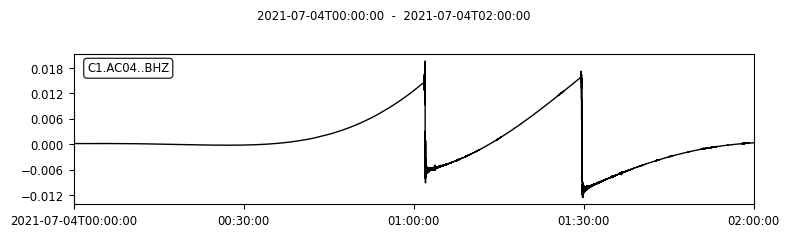

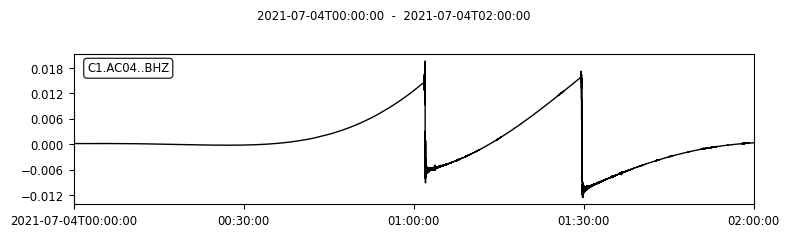

In [10]:
st_AC04_resp[2].plot(startime = st_AC04_resp[2].stats.starttime + 60*60, endtime = st_AC04_resp[2].stats.starttime + 2*60*60)

## 1.3. Filtro pasa banda

In [11]:
st_AC04 = st_AC04_resp.copy()
st_AC05 = st_AC05_resp.copy()
st_CO05 = st_CO05_resp.copy()
st_CO10 = st_CO10_resp.copy()

In [12]:
st_AC04.filter('bandpass', freqmin=4.0, freqmax=10.0) 
st_AC05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO10.filter('bandpass', freqmin=4.0, freqmax=10.0)

3 Trace(s) in Stream:
C1.CO10..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

### 1.3.1 Visualización señal filtrada 

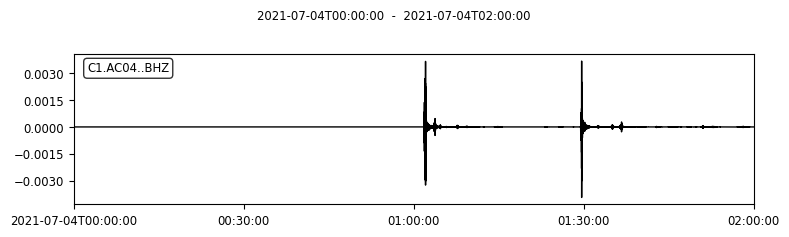

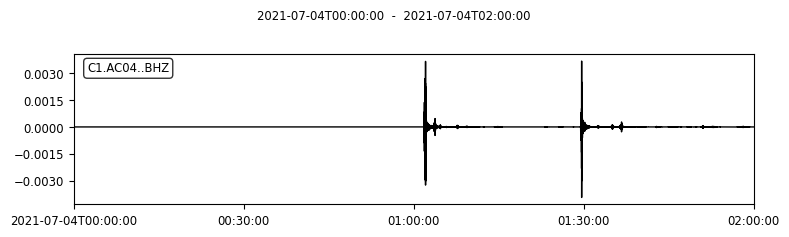

In [13]:
st_AC04[2].plot(startime = st_AC04[2].stats.starttime, endtime = st_AC04[2].stats.starttime + 60*60*2)

# 2. Cálculo de la energía para los eventos mayores que 4 en la estación más cercana al evento.

## 2.1. Cargamos el txt con los eventos mayores que 4. Este archivo ya viene con las distancias de los eventos a cada estación

In [14]:
# Ruta al archivo txt
#file_path = "times_events_24hrs_sup40.txt"  
file_path = "catalog_new_events.txt"

# Lee los datos
df = pd.read_csv(file_path)

In [15]:
df

,Fecha UTC ORIGEN,Magnitud,Inicio_CO10,Inicio_AC04,Inicio_AC05,Inicio_CO05
0,2021-07-04T01:01:37.000000Z,5.9,2021-07-04T01:01:45.750000Z,2021-07-04T01:01:50.423000Z,2021-07-04T01:01:57.030000Z,2021-07-04T01:01:57.150000Z
1,2021-07-04T01:29:15.000000Z,5.8,2021-07-04T01:29:24.500000Z,2021-07-04T01:29:28.187000Z,2021-07-04T01:29:35.186000Z,2021-07-04T01:29:35.991000Z
2,2021-07-04T01:34:42.000000Z,4.0,2021-07-04T01:34:51.000000Z,2021-07-04T01:34:53.428000Z,2021-07-04T01:35:01.173000Z,2021-07-04T01:35:02.659000Z
3,2021-07-04T01:36:16.000000Z,4.1,2021-07-04T01:36:27.571000Z,2021-07-04T01:36:30.489000Z,2021-07-04T01:36:37.501000Z,2021-07-04T01:36:37.378000Z
4,2021-07-04T02:57:48.000000Z,4.6,2021-07-04T02:57:57.904000Z,2021-07-04T02:58:01.510000Z,2021-07-04T02:58:08.730000Z,2021-07-04T02:58:09.220000Z
5,2021-07-04T04:03:22.000000Z,4.4,2021-07-04T04:03:31.701000Z,2021-07-04T04:03:35.638000Z,2021-07-04T04:03:42.773000Z,2021-07-04T04:03:43.100000Z
6,2021-07-04T04:08:09.000000Z,4.0,2021-07-04T04:08:18.682000Z,2021-07-04T04:08:22.566000Z,2021-07-04T04:08:30.000000Z,2021-07-04T04:08:30.073000Z
7,2021-07-04T15:05:28.000000Z,4.6,2021-07-04T15:05:37.674000Z,2021-07-04T15:05:41.913000Z,2021-07-04T15:05:48.934000Z,2021-07-04T15:05:49.083000Z
8,2021-07-04T15:57:11.000000Z,4.3,2021-07-04T15:57:21.000000Z,2021-07-04T15:57:23.828000Z,2021-07-04T15:57:30.855000Z,2021-07-04T15:57:32.551000Z
9,2021-07-04T19:39:24.000000Z,4.0,2021-07-04T19:39:33.100000Z,2021-07-04T19:39:38.212000Z,2021-07-04T19:39:44.529000Z,2021-07-04T19:39:44.420000Z


## 2.2 Guardamos en un diccionario la estación y tiempo de detección del evento en esa estación, para todos los eventos

In [16]:
# Inicializa un diccionario vacío para guardar los resultados
resultados = {}

stations = ['CO10','AC04', 'AC05', 'CO05']

# Itera sobre cada fila del DataFrame
for i, fila in df.iterrows():
    # Obtiene las distancias a las estaciones
    #distancias = [fila['Distancia a estación CO10'], fila['Distancia a estación AC04'], fila['Distancia a estación AC05'], fila['Distancia a estación CO05']]
    
    # Obtiene las horas de detección en las estaciones
    horas_deteccion = [fila['Inicio_CO10'], fila['Inicio_AC04'], fila['Inicio_AC05'], fila['Inicio_CO05']]
    
    # Encuentra el índice de la estación más cercana
    indice_estacion_cercana = horas_deteccion.index(min(horas_deteccion))
    
    # Guarda la estación más cercana y la hora de detección correspondiente en el diccionario
    resultados[i+1] = [stations[indice_estacion_cercana], horas_deteccion[indice_estacion_cercana]]

## 2.3. Creamos una lista con el tiempo de partida de cada evento para la estación más cercana y una lista con el nombre de la estación más cercana para cada evento

In [87]:
start_time = [UTCDateTime(resultados[clave][1]) for clave in sorted(resultados)]
closest_st_names = [resultados[clave][0] for clave in sorted(resultados)]

## 2.4. Se selecciona el canal de mayor interes para todas las estaciones

In [86]:
#selecciona el canal BHZ de AC04
st_AC04_BHZ = st_AC04.select(channel='BHZ')
#selecciona el canal BHZ de AC05
st_AC05_BHZ = st_AC05.select(channel='BHZ')
#selecciona el canal BHZ de CO05
st_CO05_BHZ = st_CO05.select(channel='BHZ')
#selecciona el canal BHZ de CO10
st_CO10_BHZ = st_CO10.select(channel='BHZ')

## 2.5 Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

In [85]:
# Crear un diccionario para mapear los nombres de las estaciones a las estaciones
stations = {
    'AC04': st_AC04_BHZ[0],
    'AC05': st_AC05_BHZ[0],
    'CO05': st_CO05_BHZ[0],
    'CO10': st_CO10_BHZ[0],
}

# Crear una lista con las estaciones más cercanas para cada evento
closest_sts_tr = [stations[estacion] for estacion in closest_st_names]


In [82]:
closest_sts_tr

[C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 H

## 2.6. Se toma para cada evento un rango de tiempo alrededor de la detección estimada y luego se visualiza

### 2.6.1. Se calcula el término del evento como el 3% de la energía del punto máximo del evento 

Tomamos en un inicio solo los primeros 60 segundos para calcular la energía máxima, de forma contraria, considera eventos futuros como los de máxima energía, quedando la cagadita. En tiempo real esto no sería necesario

In [21]:
def signal_energy(signal, window_size = 160, sample_rate = 40, hop_lenght = 160):

    # Tomamos los primeros 60 segundos
    signal = signal[:60*sample_rate]
    
    # Multiplicamos por un factor de escala para evitar errores numericos por trabajar con números muy pequeños
    data = signal*1e10

    # Calcular la energía en frames de 4 segundos 
    energy = np.convolve(data**2, np.ones(window_size), mode='valid')[::hop_lenght]

    #energy = np.array([
    #    np.sum(np.abs(data[i:i+window_size])**2)
    #    for i in range(0, len(data), hop_length)
    #])

    return energy


Ahora se toma la función anterior para calcular el termino del evento

In [22]:
def endpoint_event(signal, thr_energy = 0.03, window_size = 160):

    energy = signal_energy(signal)

    # Encontrar el pico de energía
    max_energy = np.max(energy)
    peak_index_energy = np.argmax(energy)
    ic(peak_index_energy)

    # Calcular el 3% del pico de energía
    threshold_energy = thr_energy * max_energy

    # Encontrar el punto donde la señal baja del 3% después del pico
    endpoint_energy = np.where(energy[peak_index_energy:] < threshold_energy)[0][0] + peak_index_energy
    ic(endpoint_energy)

    return peak_index_energy, endpoint_energy*window_size
    #se retorna endpoint*el largo de la ventana ya que endpoint energy entrega el frame donde se bajo del 3%, entonces necesitamos esto para tenerlo en muestras


In [88]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_traces = [sts.slice(start) for sts, start in zip(closest_sts_tr, start_time)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_traces = [endpoint_event(st.data,)[1] for st in start_traces]


ic| peak_index_energy: 2
ic| endpoint_energy: 8
ic| peak_index_energy: 3
ic| endpoint_energy: 7
ic| peak_index_energy: 2
ic| endpoint_energy: 10
ic| peak_index_energy: 1
ic| endpoint_energy: 9
ic| peak_index_energy: 2
ic| endpoint_energy: 6
ic| peak_index_energy: 2
ic| endpoint_energy: 6
ic| peak_index_energy: 1
ic| endpoint_energy: 4
ic| peak_index_energy: 2
ic| endpoint_energy: 6
ic| peak_index_energy: 1
ic| endpoint_energy: 5
ic| peak_index_energy: 1
ic| endpoint_energy: 5
ic| peak_index_energy: 2
ic| endpoint_energy: 7


In [89]:
end_events_traces

[1280, 1120, 1600, 1440, 960, 960, 640, 960, 800, 800, 1120]

### 2.6.2. Tomamos desde el incio del evento hasta el fin antes calculado 

In [90]:
pre_event = 0
post_event = end_events_traces
sample_rate = 40

sliced_traces = [traces.slice(start - pre_event, start + post_event[i]/sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr, start_time))]


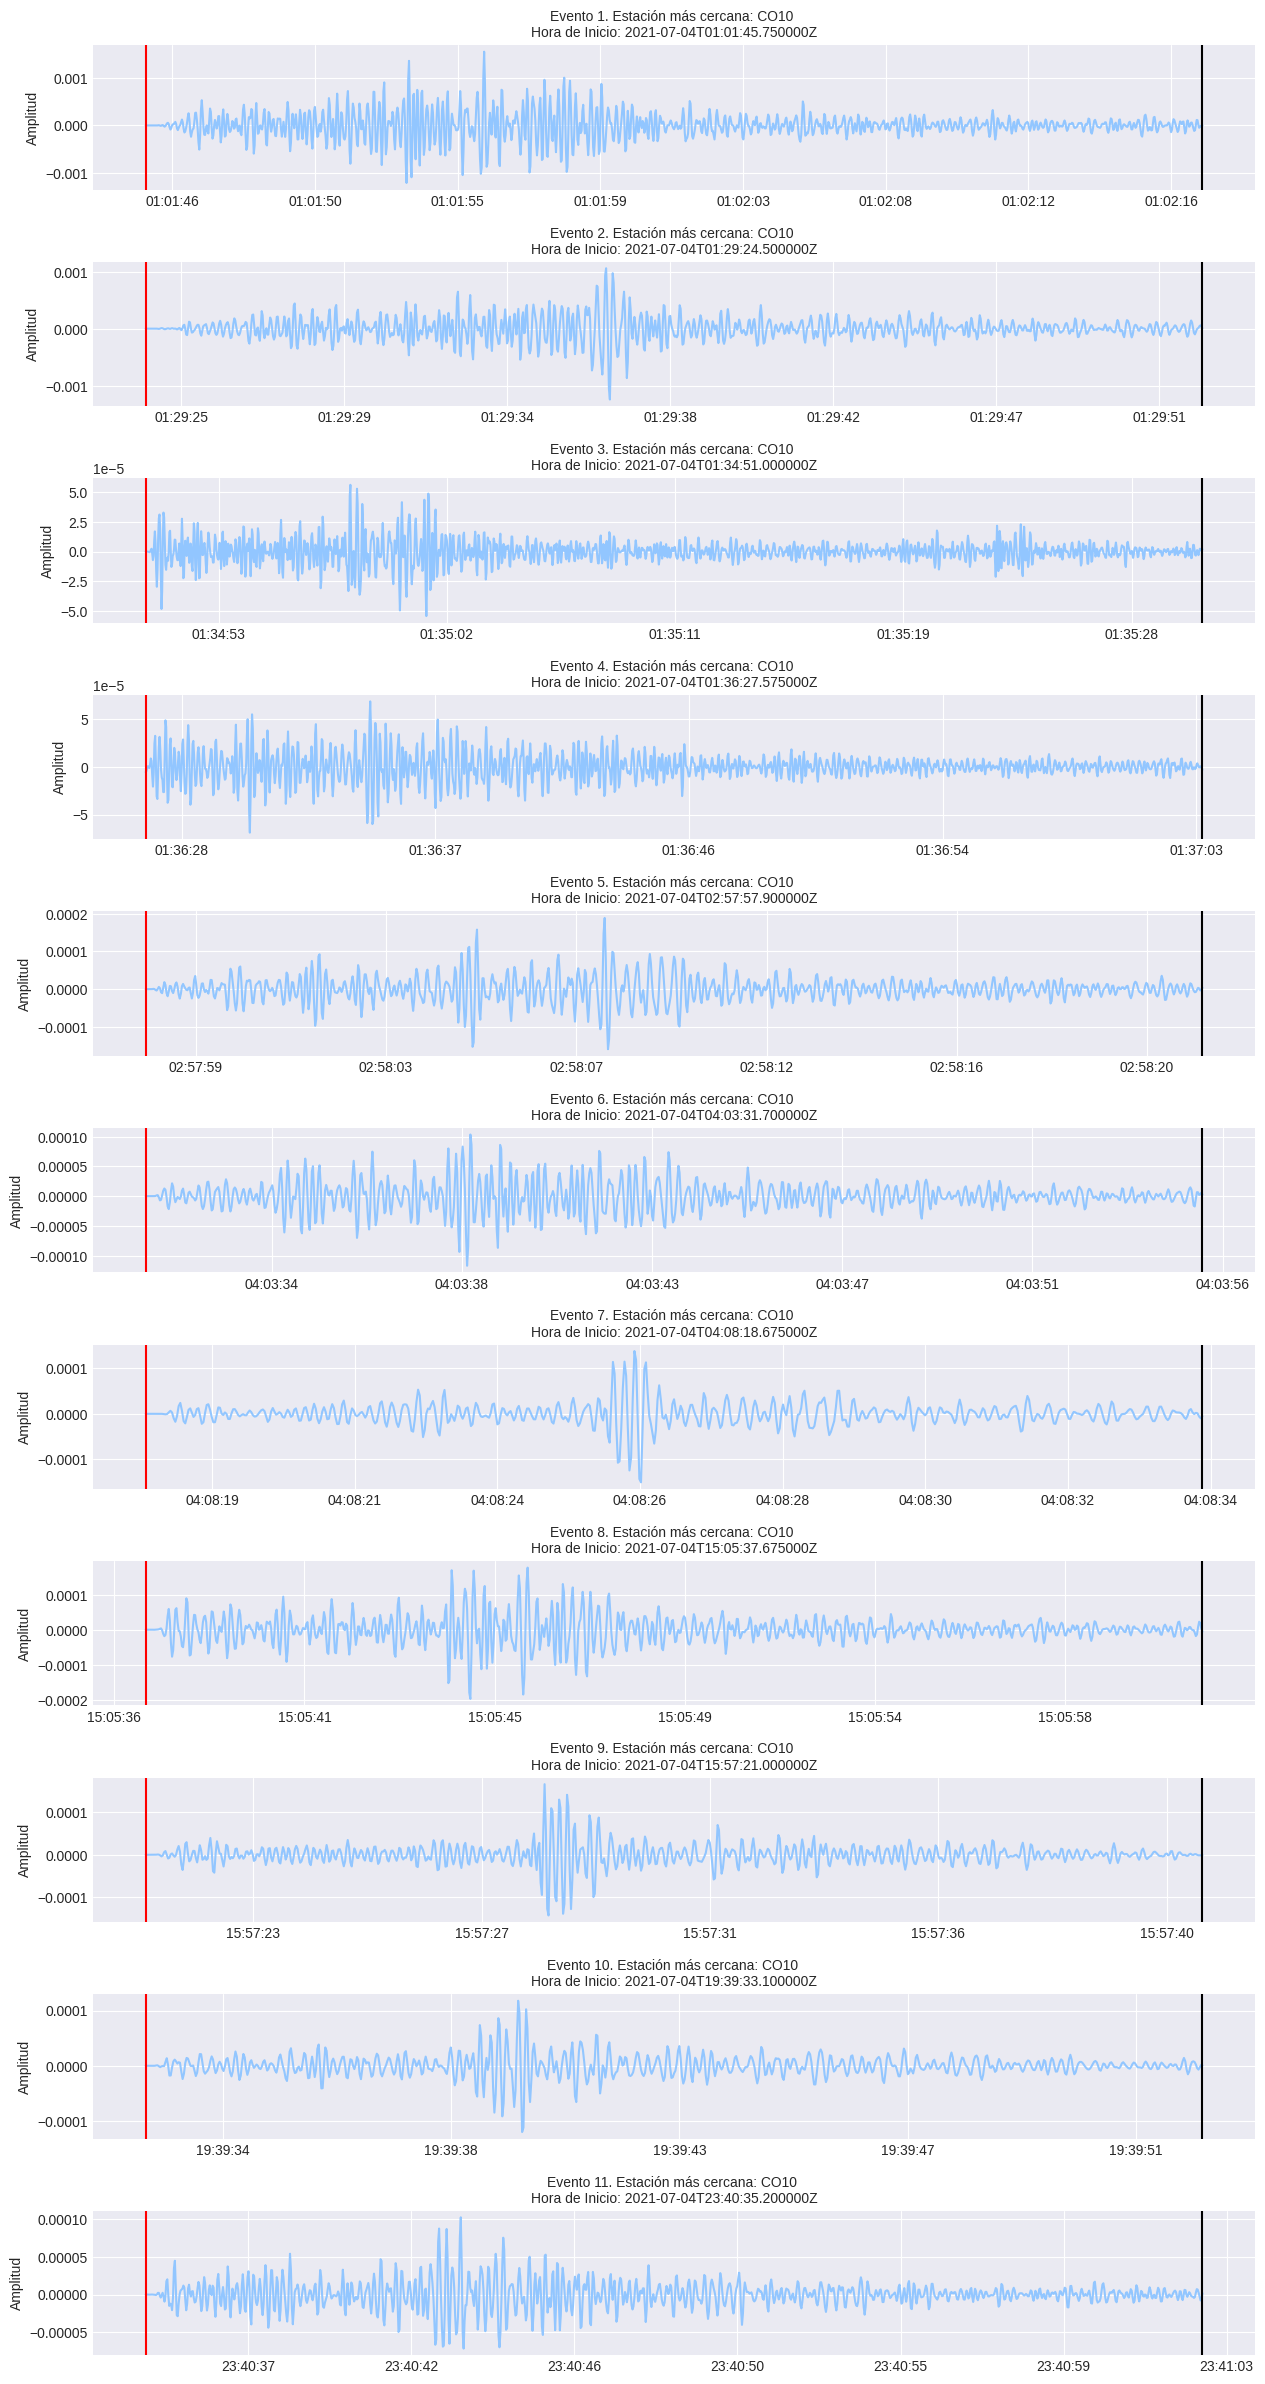

In [91]:
fig, axs = plt.subplots(len(sliced_traces), 1, figsize=(15, 30), sharex=False)
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    start = mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)
    axs[i].plot(traces.times("matplotlib"), traces.data)
    axs[i].set_title(f'Evento {i+1}. Estación más cercana: {closest_st_names[i]} \nHora de Inicio: {traces.stats.starttime + pre_event}', size=10)
    axs[i].set_ylabel('Amplitud')
    axs[i].set_xlim([axs[i].get_xlim()[0], axs[i].get_xlim()[1]])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

    # Convertir UTCDateTime a formato matplotlib
    start= mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)

    # Agregar una línea vertical roja en el tiempo de inicio del evento
    axs[i].axvline(x=start, color='r')

    # Agregar una línea vertical negra en el tiempo de finalización del evento
    axs[i].axvline(x=end, color='k')

plt.show()



In [92]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [93]:
post_event

[1280, 1120, 1600, 1440, 960, 960, 640, 960, 800, 800, 1120]

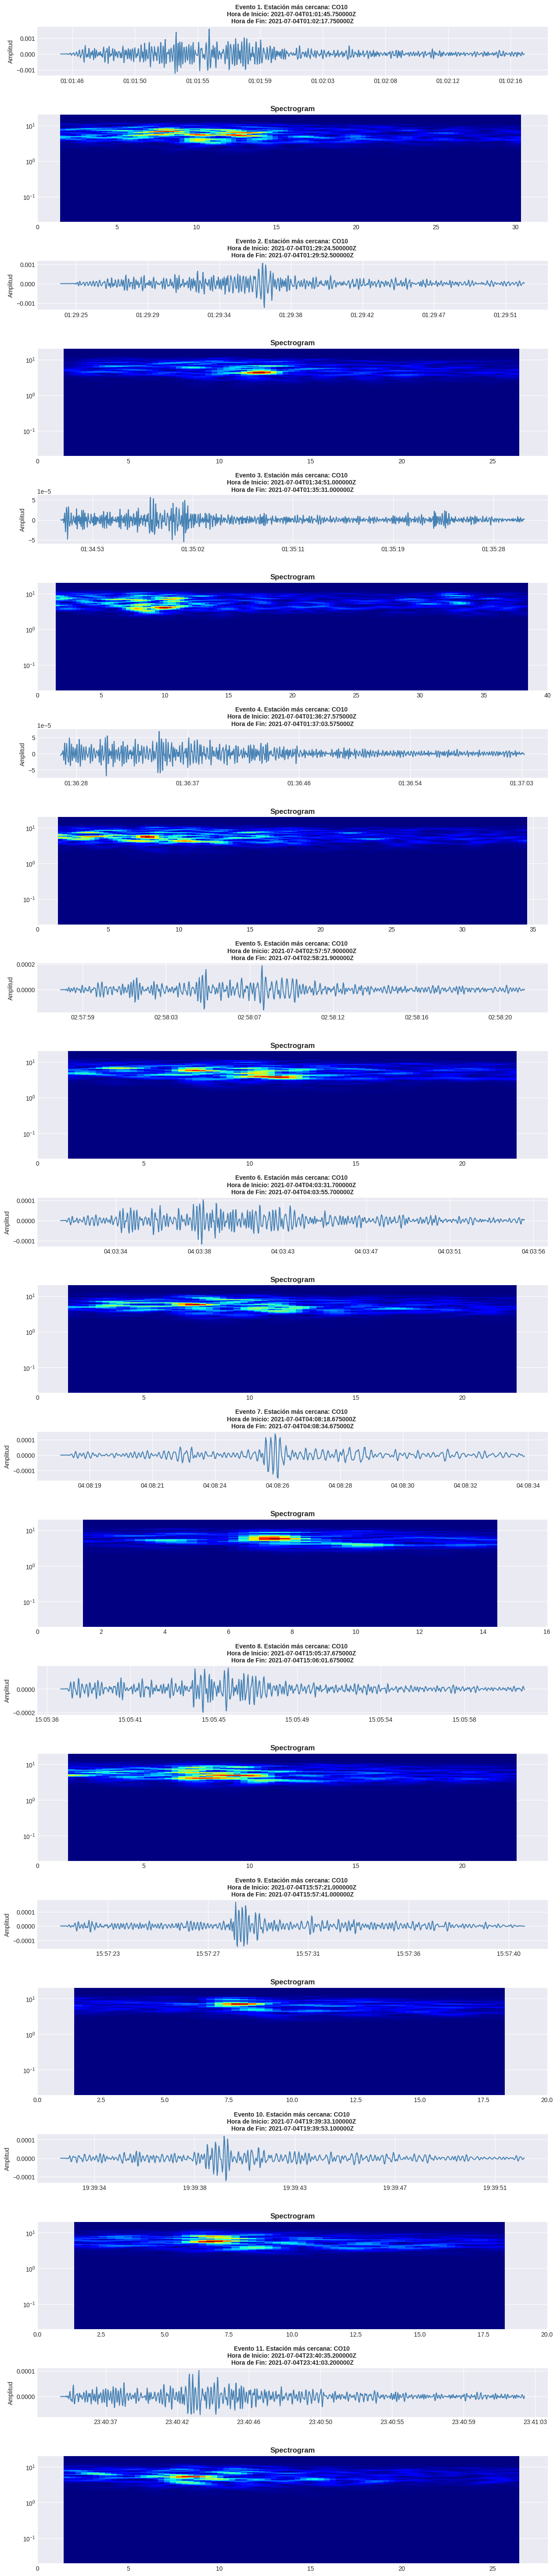

In [94]:
# Set a professional style for the plot
plt.style.use('seaborn-v0_8-darkgrid')

fig = plt.figure(figsize=(15, 75))
gs = gridspec.GridSpec(2*len(sliced_traces), 1, height_ratios=[1,2.2]*len(sliced_traces), width_ratios=[1])
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    # Plot the signal
    ax1 = plt.subplot(gs[2*i])
    ax1.plot(traces.times("matplotlib"), traces.data, color='steelblue', linewidth=1.5)
    ax1.set_title(f'Evento {i+1}. Estación más cercana: {closest_st_names[i]} \nHora de Inicio: {traces.stats.starttime + pre_event} \nHora de Fin: {traces.stats.starttime + post_event[i]/sample_rate}'
                  , size=10, fontweight='bold')
    ax1.set_ylabel('Amplitud', fontsize=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora
    ax1.grid(True)

    # Plot the spectrogram
    ax2 = plt.subplot(gs[2*i+1])
    fig = traces.spectrogram(show=False, axes=ax2, log=True, title='Spectrogram', cmap=cm.jet)
    ax2.set_title('Spectrogram', size=12, fontweight='bold')
    ax2.grid(True)

plt.show()



# 3. Cálculo de la energía suavizada.

## 3.1 Esta función devuelve el array con la energía, el punto de la traza tomada donde se encuentra el maximo de energía, y también el punto donde la energía de la señal baja del 3% de la energía máxima después del evento 

La diferencia entre usar np.mean(energy) y energy / (window_size / sample_rate) radica en cómo se interpreta la “energía” y la “potencia” en el contexto de las señales de tiempo discreto.

    np.mean(energy): Aquí estás calculando la potencia promedio de la señal. Es decir, estás sumando todas las energías (cada una calculada en una ventana de tiempo) y luego dividiendo por el número total de ventanas. Esto te da una idea de cuánta energía, en promedio, tiene la señal en cada ventana.

    energy / (window_size / sample_rate): Aquí estás dividiendo la energía total de la señal por la duración total de la señal (que es window_size / sample_rate si window_size está en muestras y sample_rate está en muestras por segundo). Esto te da la potencia promedio de la señal durante todo su tiempo de duración.

Ambos métodos son válidos para calcular la potencia, pero dan resultados ligeramente diferentes porque consideran diferentes formas de “promediar” la energía. El método que elijas depende de lo que estés tratando de analizar en tu señal. ¡Espero que esto te ayude! 

La principal diferencia entre los dos métodos es cómo se promedia la energía:

    En el primer método, estás promediando la energía en cada ventana de tiempo.
    En el segundo método, estás promediando la energía a lo largo de toda la duración de la señal.



In [100]:

np.random.seed(42)
data = np.random.randint(1, 101, size=100)
window_size = 10
sample_rate = 5

energy = np.convolve(data**2, np.ones(window_size), mode='valid')[::window_size]
print(energy)
power = energy / (window_size / sample_rate)
print(power)


[46632. 31714. 29176. 42112. 23516. 30107. 36480. 21346. 42262. 48015.]
[23316.  15857.  14588.  21056.  11758.  15053.5 18240.  10673.  21131.
 24007.5]


In [101]:
def energy_power(signal, window_size = 160, sample_rate = 40, hop_lenght = 160):

    # Multiplicamos por el factor multiplicado en el paper de estimación de magnitud
    data = signal*1e10

    # Calcular la energía en frames de 4 segundos
    energy = np.convolve(data**2, np.ones(window_size), mode='valid')[::hop_lenght]
    #energy = np.array([
    #    sum(abs(data[i:i+window_size]**2))
    #    for i in range(0, len(data), window_size)
    #])

    # Calcular la potencia como la tasa de cambio de energía con respecto al tiempo
    power = energy / (window_size / sample_rate) #basicamente energía dividio en el tiempo de cada frame. En este caso el frame sería el window_size
    #power = np.mean(energy)

    return energy, power


In [102]:
energy_events, power_events = zip(*[energy_power(st.data) for st in sliced_traces])

In [31]:
# # Crear una figura para los gráficos
#plt.figure(figsize=(15, 25))

# # Graficar la energía de cada evento
# for i, energ in enumerate(energies_events, start=1):
#     plt.subplot(len(energies_events), 1, i)
#     plt.plot(energ)
#     plt.title(f'Energía del evento {i}')
#     plt.tight_layout()

# # Mostrar los gráficos
# print(len(sliced_traces[0].data))
# plt.show()


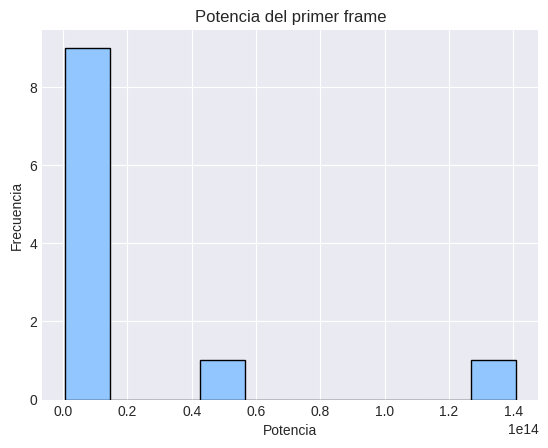

In [103]:
# Extraemos el primer elemento de cada array
first_frame = [evento[0] for evento in power_events]

# Creamos el histograma
plt.hist(first_frame, bins=10, edgecolor='black')

# Agregamos títulos y etiquetas
plt.title('Potencia del primer frame')
plt.xlabel('Potencia')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.show()

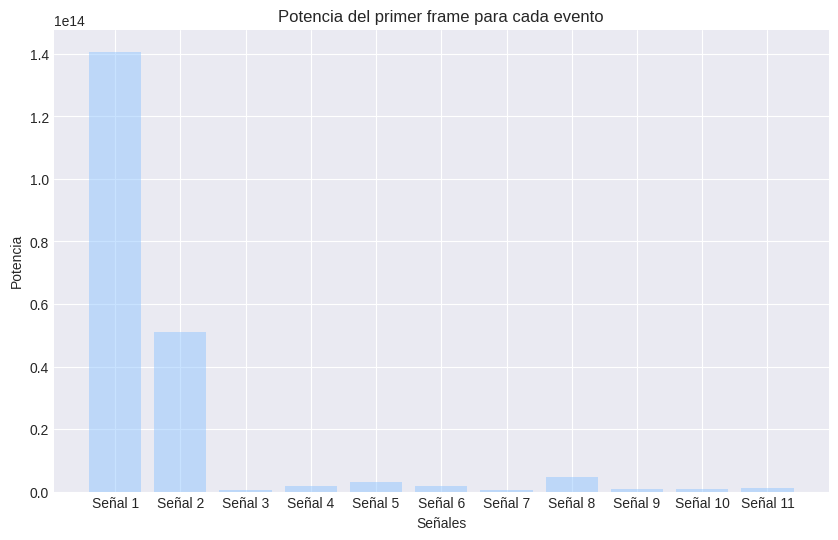

In [104]:
# Extraemos el primer elemento de cada array
primer_frame = [evento[0] for evento in power_events]

# Creamos las etiquetas para cada señal
labels = ['Señal {}'.format(i+1) for i in range(len(primer_frame))]

# Creamos una figura con un tamaño específico
plt.figure(figsize=(10, 6))

# Creamos el gráfico de barras
y_pos = np.arange(len(labels))
plt.bar(y_pos, primer_frame, align='center', alpha=0.5)
plt.xticks(y_pos, labels)

# Agregamos títulos y etiquetas
plt.title('Potencia del primer frame para cada evento')
plt.xlabel('Señales')
plt.ylabel('Potencia')

# Mostramos el gráfico
plt.show()

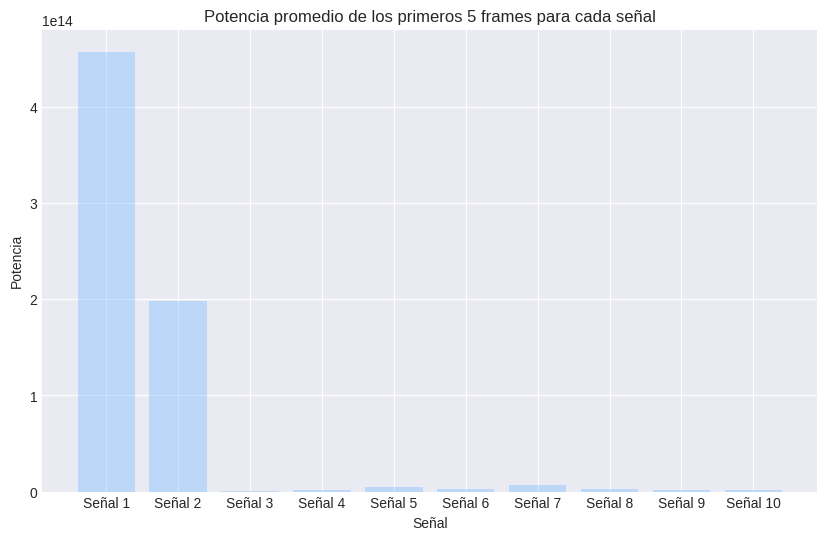

In [105]:
def plot_power_events(power_events, n):
    # Extraemos los primeros n elementos de cada array
    primeros_n_frames = [np.mean(evento[:n]) for evento in power_events if len(evento) >= n]

    # Creamos las etiquetas para cada señal
    labels = ['Señal {}'.format(i+1) for i in range(len(primeros_n_frames))]

    # Creamos una figura con un tamaño específico
    plt.figure(figsize=(10, 6))

    # Creamos el gráfico de barras
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, primeros_n_frames, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)

    # Agregamos títulos y etiquetas
    plt.title('Potencia promedio de los primeros {} frames para cada señal'.format(n))
    plt.xlabel('Señal')
    plt.ylabel('Potencia')

    # Mostramos el gráfico
    plt.show()


plot_power_events(power_events, 5)